### Imports


In [809]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

from pycaret.regression import setup, create_model, tune_model, evaluate_model, predict_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

### Load Dataset

In [810]:
df = pd.read_csv('merged_datasets.csv')
df

,Area,rooms,floor,price,elevator,exterior,district
0,64.00,2,3.00,85000,False,True,Villaverde 21
1,70.00,3,4.00,129900,True,True,Villaverde 21
2,94.00,2,1.00,144247,True,True,Villaverde 21
3,64.00,2,0.00,109900,True,True,Villaverde 21
4,108.00,2,4.00,260000,True,True,Villaverde 21
...,...,...,...,...,...,...,...
26785,90.00,3,5.00,380000,True,True,villaverde
26786,60.00,3,3.00,108000,False,True,villaverde
26787,65.00,2,0.00,140000,False,True,villaverde
26788,71.00,2,1.00,135000,False,True,villaverde


In [811]:
df.isna().sum()

Area        0
rooms       0
floor       0
price       0
elevator    0
exterior    0
district    0
dtype: int64

In [812]:
df.district.value_counts()

district
Carabanchel 3            1148
Centro 4                 1143
barrio de salamanca      1128
Tetuán 17                1107
Ciudad Lineal 7          1101
Chamberí 6               1065
Chamartín 5               928
ciudad lineal             920
tetuan                    905
Puente de Vallecas 13     870
Hortaleza 9               837
carabanchel               833
centro                    811
chamberi                  795
Arganzuela 1              791
Fuencarral 8              750
puente-de-vallecas        682
Moncloa 11                682
Villaverde 21             672
chamartin                 659
Latina 10                 638
Retiro 14                 622
latina                    614
Salamanca 15              582
Usera 18                  571
san-blas                  569
fuencarral                567
hortaleza                 560
Arganzuela                538
Villa de Vallecas 20      480
retiro                    467
moncloa                   449
usera                     445
v

In [813]:
#clean the district column to get rid of accents, hyphen and digits
def clean_district_name(name):   
    import re
    import unicodedata
    # Replace hyphens with spaces
    name = name.replace('-', ' ')
    # Remove digits
    name = re.sub(r'\d+', '', name)
    # Normalize name to remove accents
    name = unicodedata.normalize('NFKD', name).encode('ascii', 'ignore').decode('utf-8')
    # Convert to lowercase
    name = name.lower().strip()
    return name

# Apply the function to the district column
df['district'] = df['district'].apply(clean_district_name)

df.district.value_counts()

district
ciudad lineal          2021
tetuan                 2012
carabanchel            1981
centro                 1954
chamberi               1860
chamartin              1587
puente de vallecas     1552
hortaleza              1397
arganzuela             1329
fuencarral             1317
latina                 1252
moncloa                1131
barrio de salamanca    1128
villaverde             1096
retiro                 1089
usera                  1016
villa de vallecas       789
salamanca               582
san blas                569
vicalvaro               561
moratalaz               406
barajas                 161
Name: count, dtype: int64

In [755]:
#df['price_per_sqm'] = df['price']/df['Area']

In [814]:
df_sorted = df.sort_values(by='price', ascending=False)
# Display the sorted DataFrame
df_sorted.head(10)

,Area,rooms,floor,price,elevator,exterior,district
18558,170.00,5,0.00,2195000,False,True,chamartin
15999,237.00,3,3.00,2170000,True,True,barrio de salamanca
15320,153.00,3,3.00,2150000,True,True,barrio de salamanca
16235,233.00,4,4.00,2150000,True,True,barrio de salamanca
15698,171.00,3,3.00,2150000,True,True,barrio de salamanca
19287,223.00,2,4.00,2150000,True,True,chamberi
16339,213.00,1,2.00,2150000,True,True,barrio de salamanca
16246,222.00,5,6.00,2100000,True,True,barrio de salamanca
18535,222.00,4,3.00,2100000,True,True,chamartin
15347,184.00,3,2.00,2100000,True,True,barrio de salamanca


In [815]:
df.describe()

,Area,rooms,floor,price
count,"26,790.00","26,790.00","26,790.00","26,790.00"
mean,99.77,2.61,2.58,"403,254.42"
std,47.90,1.09,2.21,"296,913.73"
min,15.00,0.00,-1.00,725.00
25%,65.00,2.00,1.00,"180,000.00"
50%,88.00,3.00,2.00,"299,994.50"
75%,122.00,3.00,4.00,"545,000.00"
max,500.00,12.00,20.00,"2,195,000.00"


In [816]:
df.shape

(26790, 7)

In [817]:
# Define thresholds for Area
min_area = 15
max_area = 450

# Filter the DataFrame based on the thresholds
df_filtered = df[(df['Area'] >= min_area) & (df['Area'] <= max_area)]

# # Calculate Q1 (25th percentile) and Q3 (75th percentile) for price
Q1 = df_filtered['price'].quantile(0.30)
Q3 = df_filtered['price'].quantile(0.70)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers in price
lower_bound = max(Q1 - 1.5 * IQR, 0)  # Adjust lower bound to 0 if it's negative
upper_bound = Q3 + 1.5 * IQR
print(lower_bound, upper_bound)

# # Further filter the DataFrame based on price_per_sqft bounds
df_filtered = df_filtered[(df_filtered['price'] >= lower_bound) &
                           (df_filtered['price'] <= upper_bound)]

df_filtered.shape

0 887650.0


(24738, 7)

In [818]:
df_filtered = df_filtered[df_filtered['price'] != 725]

In [819]:
df_sorted = df_filtered.sort_values(by='price', ascending=False)
df_sorted.head(15)

,Area,rooms,floor,price,elevator,exterior,district
13020,150.00,4,4.00,887000,True,True,salamanca
11843,246.00,4,4.00,887000,True,True,centro
13323,182.00,5,2.00,886000,True,True,salamanca
8612,193.00,4,8.00,885461,True,True,ciudad lineal
19114,202.00,4,3.00,885000,True,True,chamberi
7696,220.00,5,4.00,885000,True,True,chamberi
15652,151.00,3,2.00,885000,True,True,barrio de salamanca
14655,148.00,4,4.00,885000,True,True,arganzuela
3026,218.00,2,0.00,885000,True,True,retiro
19334,97.00,2,6.00,885000,True,True,chamberi


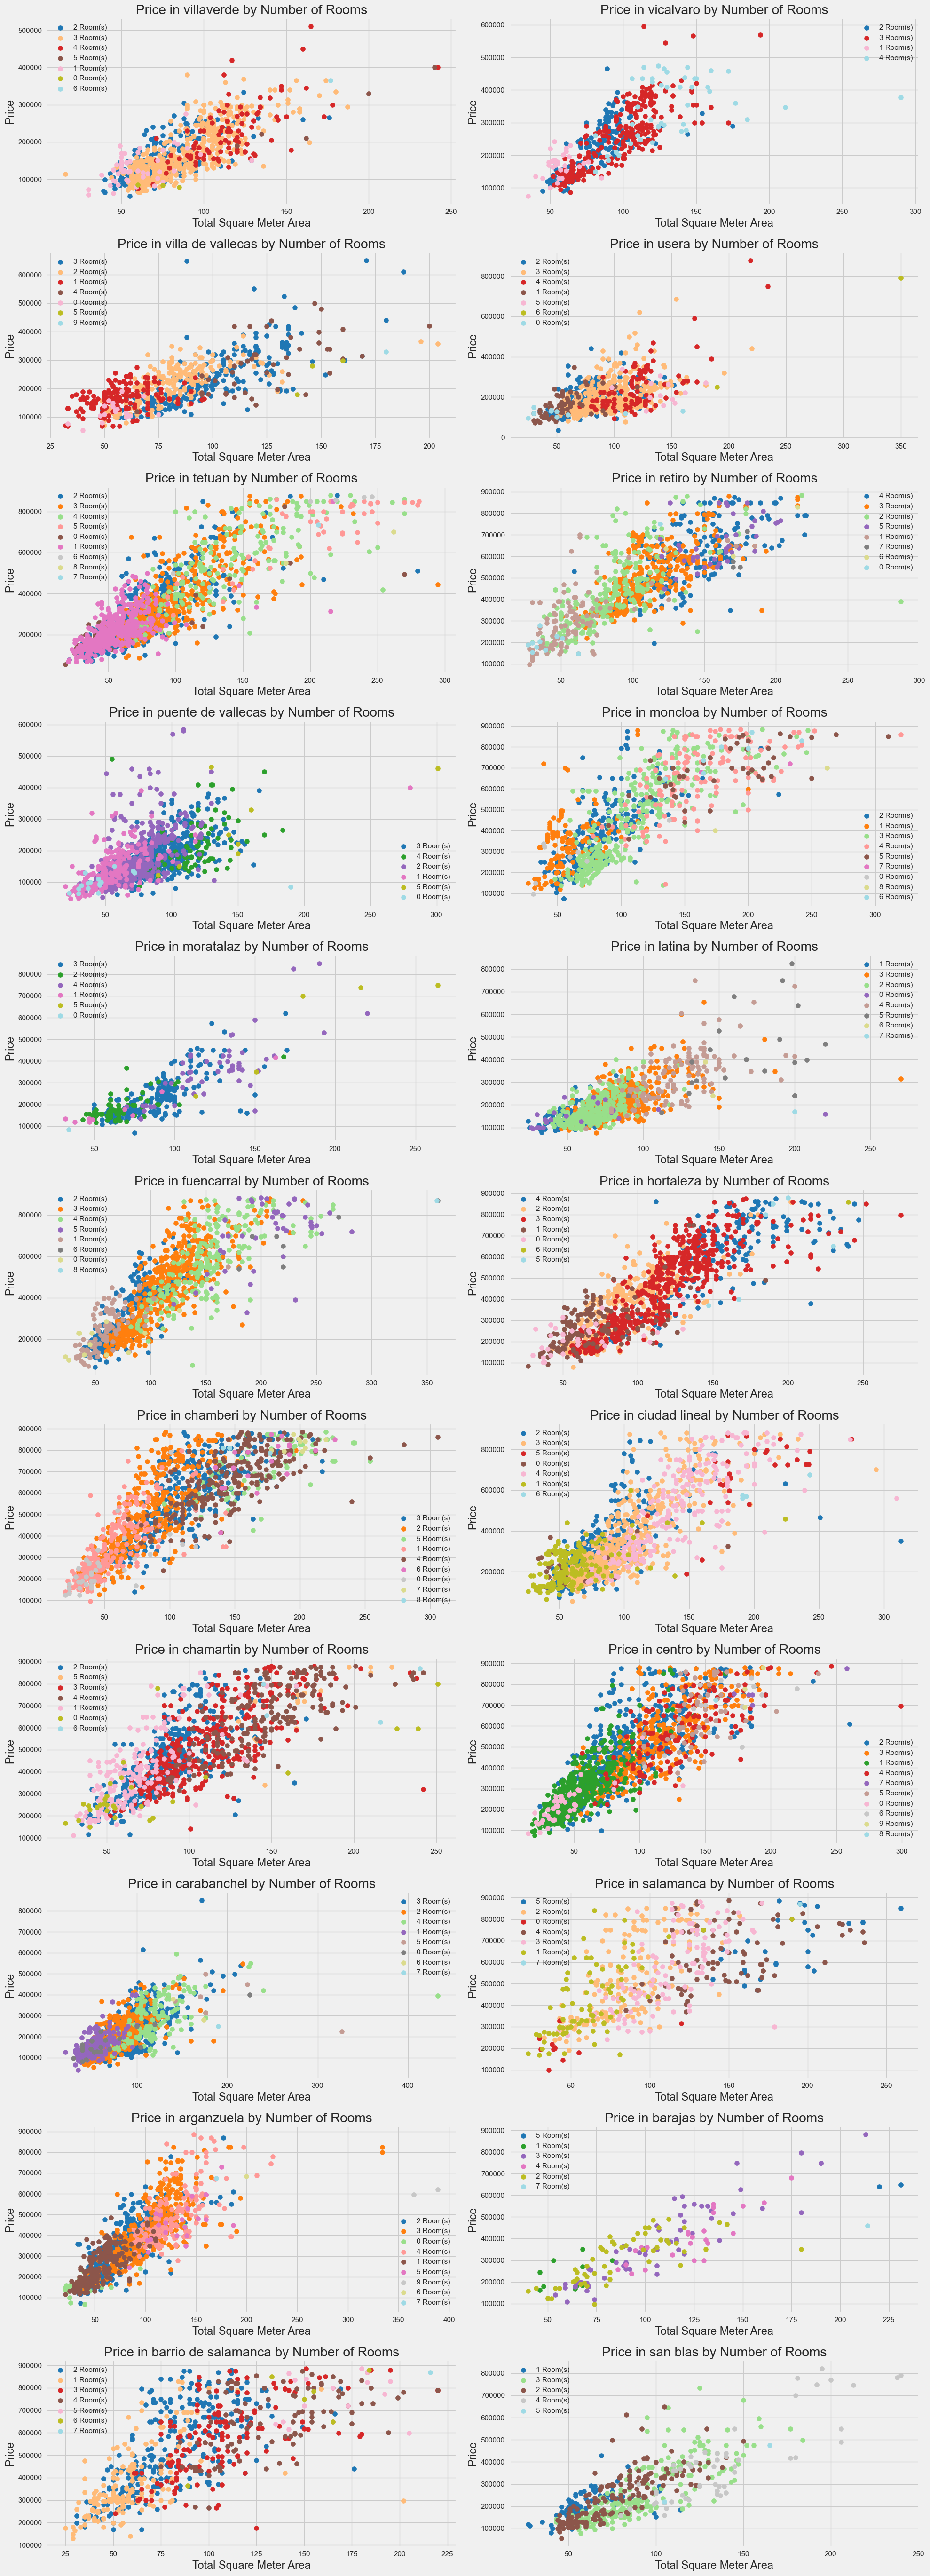

In [820]:
import matplotlib.pyplot as plt
import matplotlib

def plot_scatter_chart(ax, df, district):
    # Filter the DataFrame for the given district
    district_df = df[df['district'] == district]
    
    # Get the unique number of rooms in the district
    unique_rooms = district_df['rooms'].unique()
    
    # Define a color map for different room categories
    colors = plt.cm.get_cmap('tab20', len(unique_rooms))
    
    # Plot scatter plot for each unique room category
    for i, room in enumerate(unique_rooms):
        room_df = district_df[district_df['rooms'] == room]
        ax.scatter(room_df['Area'], room_df['price'], color=colors(i), label=f'{room} Room(s)', s=50)
    
    ax.set_xlabel("Total Square Meter Area")
    ax.set_ylabel("Price")
    ax.set_title(f"Price in {district} by Number of Rooms")
    ax.legend()

def plot_all_districts(df):
    unique_districts = df['district'].unique()
    num_districts = len(unique_districts)
    cols = 2
    rows = (num_districts + cols - 1) // cols  # Calculate the number of rows needed
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
    axes = axes.flatten()  # Flatten the axes array to make it easier to iterate
    
    for i, district in enumerate(unique_districts):
        plot_scatter_chart(axes[i], df, district)
    
    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# Apply the function to the filtered DataFrame
plot_all_districts(df_filtered)


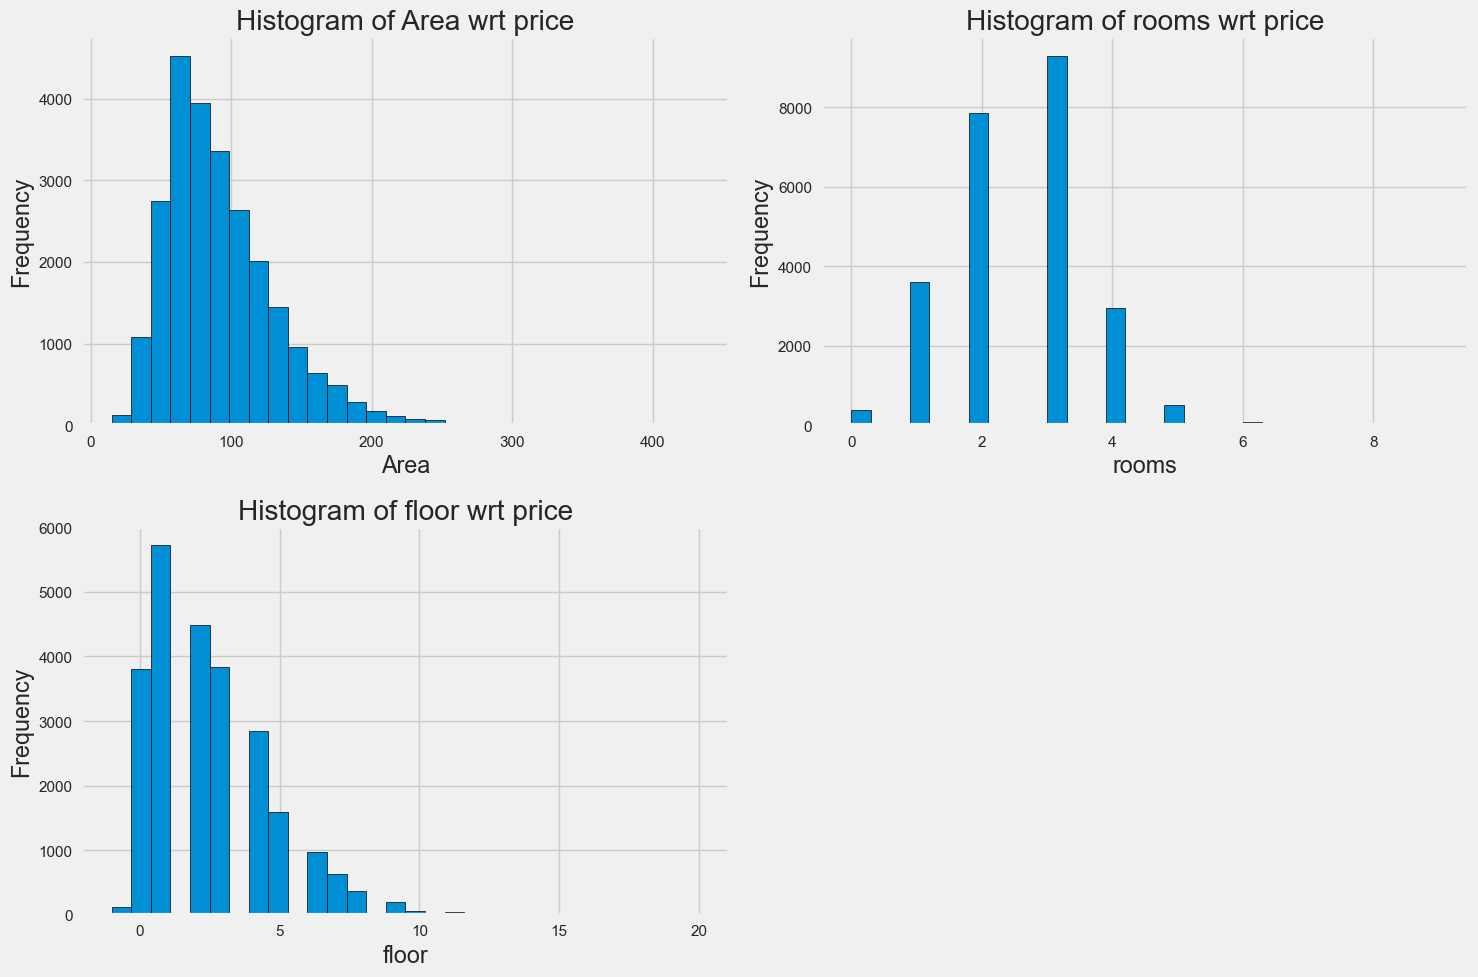

In [821]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_histograms(df, target_column='price_per_sqm'):
    # Filter out non-numeric columns
    numeric_df = df.select_dtypes(include=['number'])
    
    columns = numeric_df.columns
    num_columns = len(columns)
    cols = 2  # Number of columns for the subplot grid
    rows = (num_columns + cols - 1) // cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    
    # Flatten the axes array to make it easier to iterate
    axes = axes.flatten()
    
    for i, column in enumerate(columns):
        axes[i].hist(df[column], bins=30, edgecolor='black')
        axes[i].set_title(f'Histogram of {column} wrt {target_column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')

    # Remove any excess subplot axes that were not used
    for j in range(len(axes)):
        if j >= num_columns - 1:  # Check if the index is beyond the number of valid columns
            fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Example usage: Apply the function to the filtered DataFrame
plot_histograms(df_filtered, target_column='price')


In [822]:
df_filtered.shape

(24737, 7)

In [823]:
# Calculate the Area per room ratio
df_filtered['area_per_room'] = df_filtered['Area'] / df['rooms']

# Calculate Q1 (25th percentile) and Q3 (75th percentile) for area_per_room
Q1 = df_filtered['area_per_room'].quantile(0.25)
Q3 = df_filtered['area_per_room'].quantile(0.70)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(lower_bound, upper_bound)
print("\n")

# Filter the DataFrame to remove outliers based on area_per_room ratio
df_filtered = df_filtered[(df_filtered['area_per_room'] >= lower_bound) & 
                                     (df_filtered['area_per_room'] <= upper_bound)]

# Drop the temporary area_per_room column
df_filtered= df_filtered.drop(columns=['area_per_room'])

# Display the shape of the filtered DataFrame without outliers
print(df_filtered.shape)

# Optionally, display the top 10 rows of the cleaned DataFrame
df_filtered.head(10)


5.7499999999999964 66.15


(23122, 7)


,Area,rooms,floor,price,elevator,exterior,district
0,64.00,2,3.00,85000,False,True,villaverde
1,70.00,3,4.00,129900,True,True,villaverde
2,94.00,2,1.00,144247,True,True,villaverde
3,64.00,2,0.00,109900,True,True,villaverde
4,108.00,2,4.00,260000,True,True,villaverde
5,126.00,4,3.00,195000,False,True,villaverde
6,120.00,5,1.00,190000,False,True,villaverde
7,125.00,3,2.00,198500,False,True,villaverde
8,85.00,2,7.00,131400,False,True,villaverde
9,69.00,2,2.00,118000,False,True,villaverde


In [726]:
#df_main=df_filtered.drop('price_per_sqm',axis=1)
#df_main

In [824]:
# Convert 'elevator' and 'exterior' columns to numerical
df_filtered['elevator'] = df_filtered['elevator'].astype(int)
df_filtered['exterior'] = df_filtered['exterior'].astype(int)

In [825]:
df_sorted = df_filtered.sort_values(by='price', ascending=False)
df_sorted.head(25)

,Area,rooms,floor,price,elevator,exterior,district
11843,246.00,4,4.00,887000,1,1,centro
13020,150.00,4,4.00,887000,1,1,salamanca
13323,182.00,5,2.00,886000,1,1,salamanca
8612,193.00,4,8.00,885461,1,1,ciudad lineal
19334,97.00,2,6.00,885000,1,1,chamberi
15491,180.00,5,3.00,885000,1,1,barrio de salamanca
8496,155.00,4,3.00,885000,1,1,chamberi
14655,148.00,4,4.00,885000,1,1,arganzuela
19114,202.00,4,3.00,885000,1,1,chamberi
22209,194.00,4,1.00,885000,1,1,moncloa


### Model Training

In [826]:
from pycaret.regression import *

In [827]:
regression_setup = setup(
    data=df_filtered,
    target = 'price',
    session_id=10,
    )

,Description,Value
0,Session id,10
1,Target,price
2,Target type,Regression
3,Original data shape,"(23122, 7)"
4,Transformed data shape,"(23122, 28)"
5,Transformed train set shape,"(16185, 28)"
6,Transformed test set shape,"(6937, 28)"
7,Numeric features,5
8,Categorical features,1
9,Preprocess,True


In [828]:
# compare baseline models
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,56143.2964,6306294173.3467,79404.0321,0.8467,0.2242,0.1807,0.5960
rf,Random Forest Regressor,58851.2021,7224669027.8977,84986.2891,0.8244,0.2402,0.1901,0.3210
gbr,Gradient Boosting Regressor,61567.1756,7281234389.9299,85317.1588,0.8230,0.2477,0.2058,0.0860
lr,Linear Regression,66341.7511,8046925182.2218,89687.4718,0.8045,0.3363,0.2332,0.0120
lasso,Lasso Regression,66340.1285,8046926667.6272,89687.4709,0.8045,0.3362,0.2332,0.0120
ridge,Ridge Regression,66330.4710,8046902496.6772,89687.2986,0.8045,0.3356,0.2331,0.0090
llar,Lasso Least Angle Regression,66340.1285,8046926668.2730,89687.4709,0.8045,0.3362,0.2332,0.0120
br,Bayesian Ridge,66331.2231,8046904405.9674,89687.3121,0.8045,0.3356,0.2331,0.0130
et,Extra Trees Regressor,61654.3489,8161090583.6840,90322.4001,0.8016,0.2551,0.1992,0.2910
huber,Huber Regressor,65967.8780,8323308401.4761,91209.3141,0.7978,0.3231,0.2247,0.0420


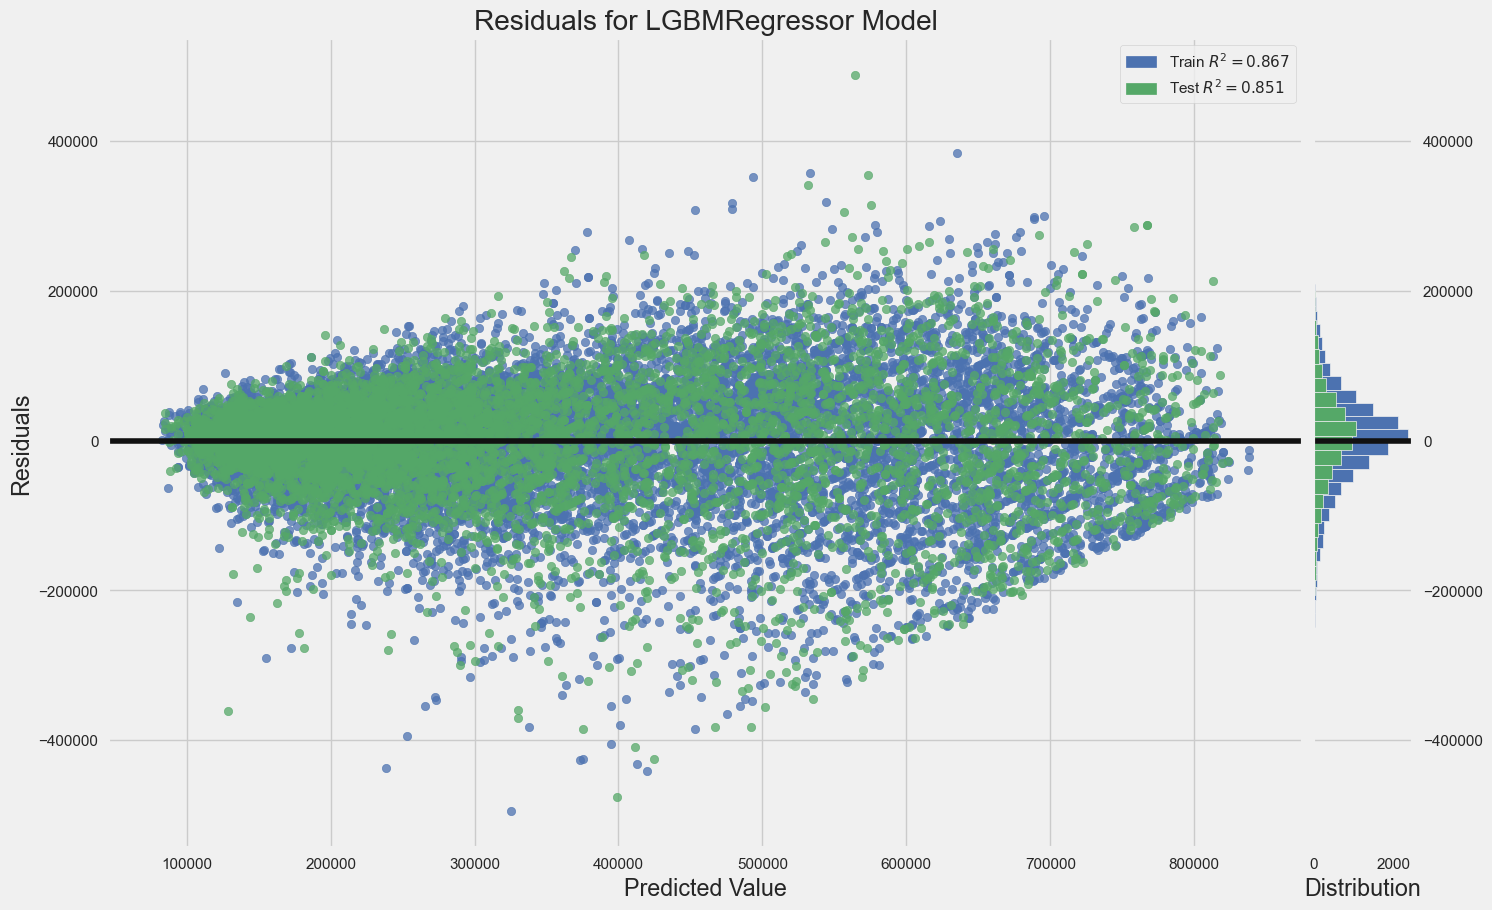

In [829]:
# plot residuals
plot_model(best_model, plot = 'residuals')

In [732]:
# Evaluate stacked model performance
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [830]:
# predict on test set
holdout_pred = predict_model(best_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,55254.8934,6128081894.6275,78282.0662,0.8513,0.2243,0.1802


In [833]:
# show predictions df
holdout_pred[['price', 'prediction_label']] = holdout_pred[['price', 'prediction_label']].astype(int)
# Add a column that shows the absolute difference
holdout_pred['absolute_difference'] = abs(holdout_pred['price'] - holdout_pred['prediction_label'])

# Sort the DataFrame by the 'absolute_difference' column
holdout_pred_sorted = holdout_pred.sort_values(by='absolute_difference', ascending = False)

print(holdout_pred_sorted[['price', 'prediction_label', 'absolute_difference']].head(20))

        price  prediction_label  absolute_difference
20891   75000            564187               489187
8702   875000            398933               476067
16353  850000            424326               425674
13122  820000            411445               408555
17315  760000            375043               384957
17389  850000            467293               382707
17224  875000            492386               382614
23858  700000            329825               370175
23323  490000            129007               360993
23876  690000            329825               360175
13331  858000            501923               356077
9496   219000            573526               354526
9600   880000            534862               345138
9031   190000            531894               341894
12346  820000            486030               333970
23702  820000            489716               330284
23427  850000            522831               327169
7612   845000            520396               

In [834]:
# Set display format to avoid scientific notation
pd.options.display.float_format = '{:,.2f}'.format
#holdout_pred_sorted[['price', 'prediction_label']] = holdout_pred_sorted[['price', 'prediction_label']].astype(int)
holdout_pred.describe()

,Area,rooms,floor,elevator,exterior,price,prediction_label,absolute_difference
count,"6,937.00","6,937.00","6,937.00","6,937.00","6,937.00","6,937.00","6,937.00","6,937.00"
mean,91.95,2.62,2.51,0.71,0.88,"338,343.18","338,384.16","55,254.84"
std,38.38,0.96,2.17,0.46,0.32,"203,022.12","186,855.92","55,456.53"
min,21.00,1.00,-1.00,0.00,0.00,"47,500.00","85,159.00",30.00
25%,64.00,2.00,1.00,0.00,1.00,"172,000.00","183,441.00","16,735.00"
50%,84.00,3.00,2.00,1.00,1.00,"275,000.00","279,122.00","38,287.00"
75%,113.00,3.00,4.00,1.00,1.00,"460,000.00","477,723.00","74,755.00"
max,360.00,8.00,20.00,1.00,1.00,"887,000.00","823,408.00","489,187.00"


In [835]:
# Calculate RMSE
rmse = np.sqrt(((holdout_pred['price'] - holdout_pred['prediction_label']) ** 2).mean())

# Calculate the range of the price
price_range = holdout_pred['price'].max() - holdout_pred['price'].min()

# Calculate Normalized RMSE
nrmse = rmse / price_range

# Display RMSE and Normalized RMSE
print(f"RMSE: {rmse}")
print(f"Normalized RMSE: {nrmse}")

RMSE: 78282.06081209362
Normalized RMSE: 0.09324843455877739


### LGBM Tuning

In [152]:
# Create LGBM
lgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,61637.9555,8600977822.8139,92741.4569,0.8633,0.2243,0.1836
1,63701.0697,9276766818.6075,96315.9738,0.8635,0.2190,0.1768
2,69387.6972,10941049312.0305,104599.4709,0.8542,0.2331,0.1947
3,68450.5920,11419444581.1120,106861.8013,0.8514,0.2277,0.1822
4,66675.8271,10250233480.8805,101243.4367,0.8622,0.2227,0.1801
5,67959.3513,11174996265.0235,105711.8549,0.8534,0.2306,0.1874
6,67105.7244,10583506071.4649,102876.1686,0.8547,0.2337,0.1904
7,68282.4196,10447805776.6328,102214.5086,0.8612,0.2259,0.1856
8,68198.6203,11306046185.8512,106329.8932,0.8468,0.2267,0.1820


In [153]:
# Tune hyperparameters of Light Gradient Boosting Machine
tuned_lgbm = tune_model(lgbm, 
                        #custom_grid = lgbm_params,
                        n_iter=70, 
                        optimize='MAE', 
                        fold=20)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,59870.9208,8615044098.3731,92817.2619,0.8633,0.2241,0.1815
1,64238.2617,8943643291.7965,94570.8374,0.8574,0.2295,0.1882
2,65373.6554,10271764477.0614,101349.7137,0.8586,0.2171,0.1762
3,61594.2032,8203112137.2795,90571.0337,0.8703,0.2150,0.1717
4,67509.2160,10961894491.7245,104699.0663,0.8494,0.2313,0.1910
5,69409.3318,10714147619.0288,103509.1668,0.8612,0.2314,0.1929
6,68439.7075,12747772171.7373,112906.0325,0.8381,0.2305,0.1825
7,65288.0488,9767462846.4280,98830.4753,0.8697,0.2180,0.1729
8,67805.9810,10294026937.7216,101459.4842,0.8549,0.2206,0.1785


Fitting 20 folds for each of 70 candidates, totalling 1400 fits


In [154]:
# predict on test set
holdout_pred_lgbm = predict_model(tuned_lgbm)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,66451.8987,10256384658.6648,101273.8103,0.8617,0.2269,0.1827


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


In [155]:
# show predictions df
holdout_pred_lgbm[['price', 'prediction_label']] = holdout_pred_lgbm[['price', 'prediction_label']].astype(int)
# Add a column that shows the absolute difference
holdout_pred_lgbm['absolute_difference'] = abs(holdout_pred_lgbm['price'] - holdout_pred_lgbm['prediction_label'])

# Sort the DataFrame by the 'absolute_difference' column
holdout_pred_lgbm_sorted = holdout_pred_lgbm.sort_values(by='absolute_difference', ascending = False)

print(holdout_pred_lgbm_sorted[['price', 'prediction_label', 'absolute_difference']].head(5))

         price  prediction_label  absolute_difference
22408  1850000           1006374               843626
18755  1690000            942207               747793
15461   585000           1287893               702893
8263    700000           1383016               683016
15919   595000           1267046               672046


In [156]:
# Calculate RMSE
rmse_lgbm = np.sqrt(((holdout_pred_lgbm['price'] - holdout_pred_lgbm['prediction_label']) ** 2).mean())

# Calculate the range of the price
price_range = holdout_pred_lgbm['price'].max() - holdout_pred_lgbm['price'].min()

# Calculate Normalized RMSE
nrmse_lgbm = rmse_lgbm / price_range

# Display RMSE and Normalized RMSE
print(f"RMSE_lgbm: {rmse_lgbm}")
print(f"Normalized RMSE_lgbm: {nrmse_lgbm}")

RMSE_lgbm: 101273.81270939628
Normalized RMSE_lgbm: 0.05635715787946371


### Stacked Model

In [836]:
# Create and tune other models
#rf = create_model('rf')
#lgbm  = create_model('lightgbm')
#gbr = create_model('gbr')

# Tune the models
#tuned_rf = tune_model(rf, n_iter=50, optimize='RMSE', fold=15)
#tuned_gbr = tune_model(gbr, n_iter=50, optimize='RMSE', fold=15)
#tuned_lgbm = tune_model(lgbm, n_iter=50, optimize='RMSE', fold=15)

# Create multiple instances of Gradient Boosting Regressor with different configurations
lgbm1 = create_model('lightgbm')  # Default configuration
lgbm2 = create_model('lightgbm', learning_rate=0.1, max_depth=5)  # Tuned configuration 1
lgbm3 = create_model('lightgbm', learning_rate=0.09, max_depth=5)  

stacked_model = stack_models(estimator_list=[lgbm3, lgbm2, lgbm1])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,56584.8859,6391573141.7589,79947.3148,0.8395,0.2259,0.1841
1,57663.9039,6685324075.7285,81763.8311,0.8367,0.2256,0.1809
2,56557.3939,6499828223.8750,80621.5122,0.8493,0.2265,0.1824
3,55995.5855,6181236527.0947,78620.8403,0.8573,0.2253,0.1808
4,55894.8361,6309272142.3588,79430.9269,0.8475,0.2242,0.1817
5,55102.4997,6060379287.3097,77848.4379,0.8437,0.2226,0.1807
6,56005.6184,6342127745.5794,79637.4770,0.8514,0.2233,0.1785
7,55740.4602,6187756153.9122,78662.2918,0.8408,0.2239,0.1786
8,56411.0068,6319976194.3659,79498.2779,0.8429,0.2238,0.1838


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,57680.2625,6541019351.4393,80876.5686,0.8358,0.2307,0.1887
1,58588.9384,6876640381.6018,82925.5110,0.8320,0.2299,0.1855
2,57722.5665,6675631911.1164,81704.5403,0.8452,0.2310,0.1876
3,56542.3352,6330674611.7752,79565.5366,0.8539,0.2290,0.1838
4,56865.7319,6460532336.7618,80377.4367,0.8439,0.2300,0.1875
5,56173.9038,6305430873.4032,79406.7432,0.8374,0.2279,0.1857
6,56854.2367,6487725432.3167,80546.4179,0.8480,0.2276,0.1832
7,55963.6514,6207010449.9003,78784.5826,0.8403,0.2242,0.1802
8,57220.1255,6486617704.4568,80539.5412,0.8388,0.2284,0.1872


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,57594.6252,6491960269.7958,80572.7018,0.8370,0.2311,0.1892
1,59223.1146,6946456221.7311,83345.4031,0.8303,0.2318,0.1886
2,58213.0620,6743191998.9466,82116.9410,0.8436,0.2328,0.1900
3,56811.1043,6361569066.8751,79759.4450,0.8532,0.2299,0.1855
4,57082.2623,6528944177.0641,80801.8823,0.8422,0.2314,0.1887
5,56686.2707,6407799809.7844,80048.7340,0.8348,0.2305,0.1883
6,57378.6565,6571299595.0683,81063.5528,0.8460,0.2295,0.1852
7,56154.9590,6213174467.1478,78823.6923,0.8402,0.2253,0.1818
8,57763.9942,6526702388.6055,80788.0089,0.8378,0.2301,0.1898


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,56478.4616,6355632726.2527,79722.2223,0.8404,0.2254,0.1833
1,57666.4949,6696902339.8771,81834.6036,0.8364,0.2255,0.1805
2,56484.7966,6480056474.8533,80498.7980,0.8497,0.2261,0.1819
3,55781.3549,6155885586.3844,78459.4519,0.8579,0.2246,0.1796
4,55788.7429,6273536328.8642,79205.6584,0.8484,0.2241,0.1816
5,55007.4623,6066594196.7311,77888.3444,0.8436,0.2222,0.1801
6,55916.3635,6326619905.5571,79540.0522,0.8518,0.2230,0.1781
7,55533.6842,6142775014.3710,78375.8573,0.8420,0.2225,0.1775
8,56250.0131,6309042443.6138,79429.4809,0.8432,0.2233,0.1827


In [698]:
# Evaluate stacked model performance
evaluate_model(stacked_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [782]:
# Predict on test set with stacked model
holdout_pred_stacked = predict_model(stacked_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,55785.8109,6174734154.3916,78579.4767,0.8543,0.2226,0.1797


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [783]:
# show predictions df
holdout_pred_stacked[['price', 'prediction_label']] = holdout_pred_stacked[['price', 'prediction_label']].astype(int)
# Add a column that shows the absolute difference
holdout_pred_stacked['absolute_difference'] = abs(holdout_pred_stacked['price'] - holdout_pred_stacked['prediction_label'])

# Sort the DataFrame by the 'absolute_difference' column
holdout_pred_stacked = holdout_pred_stacked.sort_values(by='absolute_difference', ascending = False)

print(holdout_pred_stacked[['price', 'prediction_label', 'absolute_difference']].head(5))

        price  prediction_label  absolute_difference
16209  175000            649101               474101
21693  890000            461189               428811
9501   838000            441917               396083
16163  839000            444568               394432
9496   219000            605466               386466


In [784]:
# Calculate RMSE
rmse_stacked = np.sqrt(((holdout_pred_stacked['price'] - holdout_pred_stacked['prediction_label']) ** 2).mean())

# Calculate the range of the price
price_range = holdout_pred_stacked['price'].max() - holdout_pred_stacked['price'].min()

# Calculate Normalized RMSE
nrmse_stacked = rmse_stacked/ price_range

# Display RMSE and Normalized RMSE
print(f"RMSE_stacked: {rmse_stacked}")
print(f"Normalized RMSE_stacked: {nrmse_stacked}")

RMSE_stacked: 78579.46661514362
Normalized RMSE_stacked: 0.08991752730287196
